In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Reshape, Conv2D, Conv1D
from tensorflow.keras import models
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D
import math
import numpy as np
 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
NAME = 'three_image(3_label)'

TRAIN_SAMPLES = 15926
VALIDATION_SAMPLES = 1990
IMG_WIDTH, IMG_HEIGHT = 128, 128
BATCH_SIZE = 64
EPOCH = 100

In [ ]:
# https://github.com/keras-team/keras/issues/9969#issuecomment-420371428
# https://stackoverflow.com/questions/59492866/keras-imagedatagenerator-for-multiple-inputs-and-image-based-target-output
class JoinedGen(tf.keras.utils.Sequence):
    def __init__(self, input_gen1, input_gen2, input_gen3):
        self.gen1 = input_gen1
        self.gen2 = input_gen2
        self.gen3 = input_gen2

        assert len(input_gen1) == len(input_gen2)  == len(input_gen3)

    def __len__(self):
        return len(self.gen1)

    def __getitem__(self, i):
        x1, y1 = self.gen1[i]
        x2, y2 = self.gen2[i]
        x3, y3 = self.gen3[i]
        return [x1, x2, x3], y1

    def on_epoch_end(self):
        self.gen1.on_epoch_end()
        self.gen2.on_epoch_end()
        self.gen3.on_epoch_end()
        self.gen2.index_array = self.gen1.index_array
        self.gen3.index_array = self.gen1.index_array

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
                                   rotation_range=45,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   zoom_range=0.3,
                                   vertical_flip =True,
                                   horizontal_flip =True)
 
val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train_generator1 = train_datagen.flow_from_directory(f'../../data/{NAME}/sat/train',
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')
train_generator2 = train_datagen.flow_from_directory(f'../../data/{NAME}/dem/train',
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')
train_generator3 = train_datagen.flow_from_directory(f'../../data/{NAME}/road/train',
                                                    target_size=(IMG_WIDTH,
                                                                 IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=12345,
                                                    class_mode='categorical')
validation_generator1 = val_datagen.flow_from_directory(
    f'../../data/{NAME}/sat/val',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical')
validation_generator2 = val_datagen.flow_from_directory(
    f'../../data/{NAME}/dem/val',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical')
validation_generator3 = val_datagen.flow_from_directory(
    f'../../data/{NAME}/road/val',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical')

Found 15926 images belonging to 3 classes.
Found 15926 images belonging to 3 classes.
Found 15926 images belonging to 3 classes.
Found 1990 images belonging to 3 classes.
Found 1990 images belonging to 3 classes.
Found 1990 images belonging to 3 classes.


In [ ]:
train_generator = JoinedGen(train_generator1, train_generator2, train_generator3)
validation_generator = JoinedGen(validation_generator1, validation_generator2, validation_generator3)

학습

In [ ]:
def model_maker(num_class, input_shape=(224, 224, 3)):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=input_shape , weights='imagenet')
    base_model2 = tf.keras.applications.MobileNetV2( include_top=False, input_shape=input_shape , weights='imagenet')
    base_model3 = tf.keras.applications.MobileNetV2( include_top=False, input_shape=input_shape , weights='imagenet')
    # print(len(base_model.layers))
    base_model._name = 'mobilenetv2_1'
    base_model2._name = 'mobilenetv2_2'
    base_model3._name = 'mobilenetv2_3'
 

    # base_model.trainable = True
    for layer in base_model.layers[:130]:
        layer.trainable = False 
    for layer in base_model2.layers[:130]:
        layer.trainable = False 
    for layer in base_model3.layers[:130]:
        layer.trainable = False 
            
    sat_input = tf.keras.Input(shape=input_shape)
    sat_custom_model = base_model(sat_input)
    sat_custom_model = tf.keras.layers.GlobalAveragePooling2D()(sat_custom_model)
    sat_custom_model = tf.keras.layers.Dropout(0.5)(sat_custom_model)
    sat_custom_model = tf.keras.layers.Dense(256, activation='relu')(sat_custom_model)

    dem_input = tf.keras.Input(shape=input_shape)
    dem_custom_model = base_model2(dem_input)
    dem_custom_model = tf.keras.layers.GlobalAveragePooling2D()(dem_custom_model)
    dem_custom_model = tf.keras.layers.Dropout(0.2)(dem_custom_model)
    dem_custom_model = tf.keras.layers.Dense(256, activation='relu')(dem_custom_model)  

    road_input = tf.keras.Input(shape=input_shape)
    road_custom_model = base_model3(road_input)
    road_custom_model = tf.keras.layers.GlobalAveragePooling2D()(road_custom_model)
    road_custom_model = tf.keras.layers.Dropout(0.2)(road_custom_model)
    road_custom_model = tf.keras.layers.Dense(256, activation='relu')(road_custom_model)

    sum_custom_model = tf.keras.layers.concatenate([sat_input, road_input, dem_input])
    sum_custom_model = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(sum_custom_model)
    sum_custom_model =  tf.keras.layers.MaxPool2D(pool_size=(2, 2))(sum_custom_model)
    sum_custom_model = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(sum_custom_model)
    sum_custom_model =  tf.keras.layers.MaxPool2D(pool_size=(2, 2))(sum_custom_model)
    sum_custom_model = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(sum_custom_model)
    sum_custom_model = tf.keras.layers.GlobalAveragePooling2D()(sum_custom_model)
    sum_custom_model = tf.keras.layers.Dropout(0.2)(sum_custom_model)
    sum_custom_model = tf.keras.layers.Dense(256, activation='relu')(sum_custom_model)


    custom_model = tf.keras.layers.concatenate([sat_custom_model, dem_custom_model, road_custom_model, sum_custom_model])
    custom_model = tf.keras.layers.Dense(64, activation='relu')(custom_model)

    custom_model = tf.keras.layers.Dense(32, activation='relu')(custom_model)
    predictions = tf.keras.layers.Dense(num_class, activation='softmax')(custom_model)
    
    return tf.keras.Model(inputs=[sat_input, dem_input, road_input], outputs=predictions)

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      tf.keras.metrics.CategoricalAccuracy(name='accuracy')
]

model_final = model_maker(3, input_shape=(IMG_HEIGHT, IMG_HEIGHT, 3))
model_final.summary()
model_final.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=METRICS)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                            

In [ ]:
checkpoint_path = f"./{NAME}_MobileNet__3image4/cp-{EPOCH:04d}.ckpt"   # 3
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 save_best_only=True)

import sklearn
class_weights = sklearn.utils.class_weight.compute_class_weight(
            class_weight = 'balanced',
            classes = np.unique(train_generator1.classes), 
            y = train_generator1.classes)

class_weights = dict(enumerate(class_weights))

history = model_final.fit(
    train_generator,
    steps_per_epoch=TRAIN_SAMPLES // (BATCH_SIZE), # number of updates
    epochs=EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_SAMPLES // (BATCH_SIZE ),
    callbacks=[cp_callback ],
    class_weight=class_weights,
    workers=8)

Epoch 1/100
248/248 [==============================] - ETA: 0s - loss: 0.9239 - tp: 5822.0000 - fp: 2549.0000 - tn: 29175.0000 - fn: 10040.0000 - precision: 0.6955 - recall: 0.3670 - auc: 0.7589 - prc: 0.6559 - accuracy: 0.5499
Epoch 1: val_accuracy improved from -inf to 0.47883, saving model to ./two_image(3_label)_MobileNet__3image\cp-0100.ckpt
248/248 [==============================] - 73s 228ms/step - loss: 0.9239 - tp: 5822.0000 - fp: 2549.0000 - tn: 29175.0000 - fn: 10040.0000 - precision: 0.6955 - recall: 0.3670 - auc: 0.7589 - prc: 0.6559 - accuracy: 0.5499 - val_loss: 1.0956 - val_tp: 780.0000 - val_fp: 673.0000 - val_tn: 3295.0000 - val_fn: 1204.0000 - val_precision: 0.5368 - val_recall: 0.3931 - val_auc: 0.6899 - val_prc: 0.5822 - val_accuracy: 0.4788
Epoch 2/100
248/248 [==============================] - ETA: 0s - loss: 0.8513 - tp: 6704.0000 - fp: 2873.0000 - tn: 28851.0000 - fn: 9158.0000 - precision: 0.7000 - recall: 0.4226 - auc: 0.7980 - prc: 0.7003 - accuracy: 0.5827


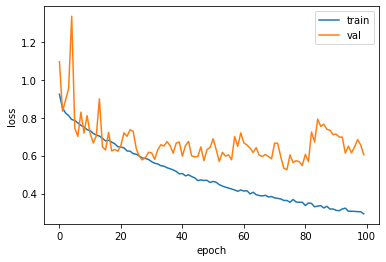

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

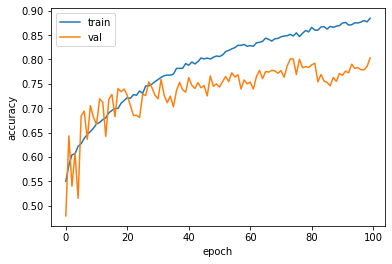

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

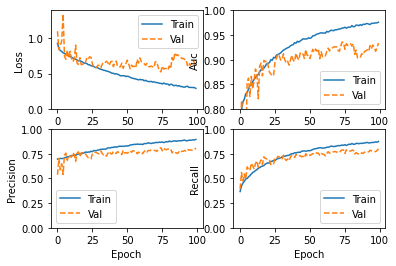

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
plot_metrics(history)

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
 
 
test_generator1 = test_datagen.flow_from_directory(
    f'../../data/{NAME}/sat/test',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')
 
test_generator2 = test_datagen.flow_from_directory(
    f'../../data/{NAME}/dem/test',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')
test_generator3 = test_datagen.flow_from_directory(
    f'../../data/{NAME}/road/test',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')
test_generator = JoinedGen(test_generator1, test_generator2, test_generator3)

Found 1997 images belonging to 3 classes.
Found 1997 images belonging to 3 classes.
Found 1997 images belonging to 3 classes.


In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model_final.load_weights(latest)

model_final.evaluate(test_generator, steps=VALIDATION_SAMPLES // BATCH_SIZE)


31/31 [==============================] - 9s 271ms/step - loss: 0.5818 - tp: 1614.0000 - fp: 348.0000 - tn: 3620.0000 - fn: 370.0000 - precision: 0.8226 - recall: 0.8135 - auc: 0.9380 - prc: 0.8908 - accuracy: 0.8191


[0.5818123817443848,
 1614.0,
 348.0,
 3620.0,
 370.0,
 0.822629988193512,
 0.8135080933570862,
 0.9380128383636475,
 0.890826940536499,
 0.8190523982048035]

In [ ]:
# model_final.save(f'./{NAME}_MobileNet_3image.h5')

tf.saved_model.save(model_final, 'saved_model')

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets
